__In this notebook we explore the following topics:__

- Data Generators
- Overfitting
- Data Augmentation


# CIFAR-10

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

In [3]:
import tensorflow.keras as keras
import numpy as np
keras.__version__

'2.6.0'

## Dataset

**CIFAR-10** [(Krizhevsky, 2009)](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf): 60000 32x32 colour images in 10 classes, with 6000 images per class (50000 training images and 10000 test images). Very widely used today for testing performance of new algorithms. This fast.ai datasets version uses a standard PNG format instead of the platform-specific binary formats of the original, so you can use the regular data pipelines in most libraries.

On your own machine, you can download this data like so:

```
!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
```

And unzip

```
!tar -xf cifar10.tgz
```

However, we have already downloaded this data on ALCF and made it avaialable at `/lus/grand/projects/ALCFAITP/cifar10/`

In [4]:
data_dir = '/lus/grand/projects/ALCFAITP/cifar10/'

The dataset is already in ImageNet folder format, i.e. each class has a directory that contains all the pictures belonging to that class

In [5]:
!ls /lus/grand/projects/ALCFAITP/cifar10/

test  train


In [6]:
!ls /lus/grand/projects/ALCFAITP/cifar10/train/

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


### Intro. to using Datagenerators 

In some cases of large datasets, even the most state-of-the-art configuration won't have enough memory space to hold all the data at the same time. Hence we need to find other ways to do the task of feeding batched of data into deep learning models efficiently.

Keras already has a native implementation of Image data generators that takes care of reading batches of data and feeding into Deep Neural Nets (see https://keras.io/preprocessing/image/). Addititionally the data generator implementation in keras has convenient functions for preprocessing of data such as rescaling, augmenting and whitening, etc. 

Additionally, we need to format our datat into appropriately pre-processed floating point tensors before feeding into our network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

- Read the picture files.
- Decode the JPEG content to RBG grids of pixels.
- Convert these into floating point tensors.
- Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

It may seem a bit daunting, but thankfully the data generator implementation in keras has convenient functions for preprocessing of data such as rescaling, augmenting and whitening, etc. 

Lastly, the ImageDataGenerator in keras has an in-built method called `flow_from_directory` that exploits the ImageNet directory structure off the shelf.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        directory=data_dir+'/train/',
        # All images will be resized to 32x32
        target_size=(32, 32),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        directory=data_dir+'/test/',
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape (32, 150, 150, 3)) and categorical labels (shape (32,10)). 32 is the number of samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to break the iteration loop at some point.

In [9]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 32, 32, 3)
labels batch shape: (32, 10)


### Visualize a sample of Training Data 

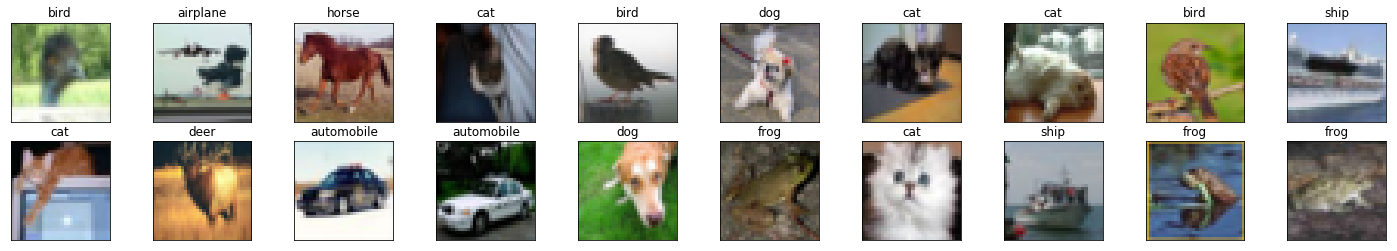

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
images, labels = train_generator.next()[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    ax.set_title(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(labels[idx]))])

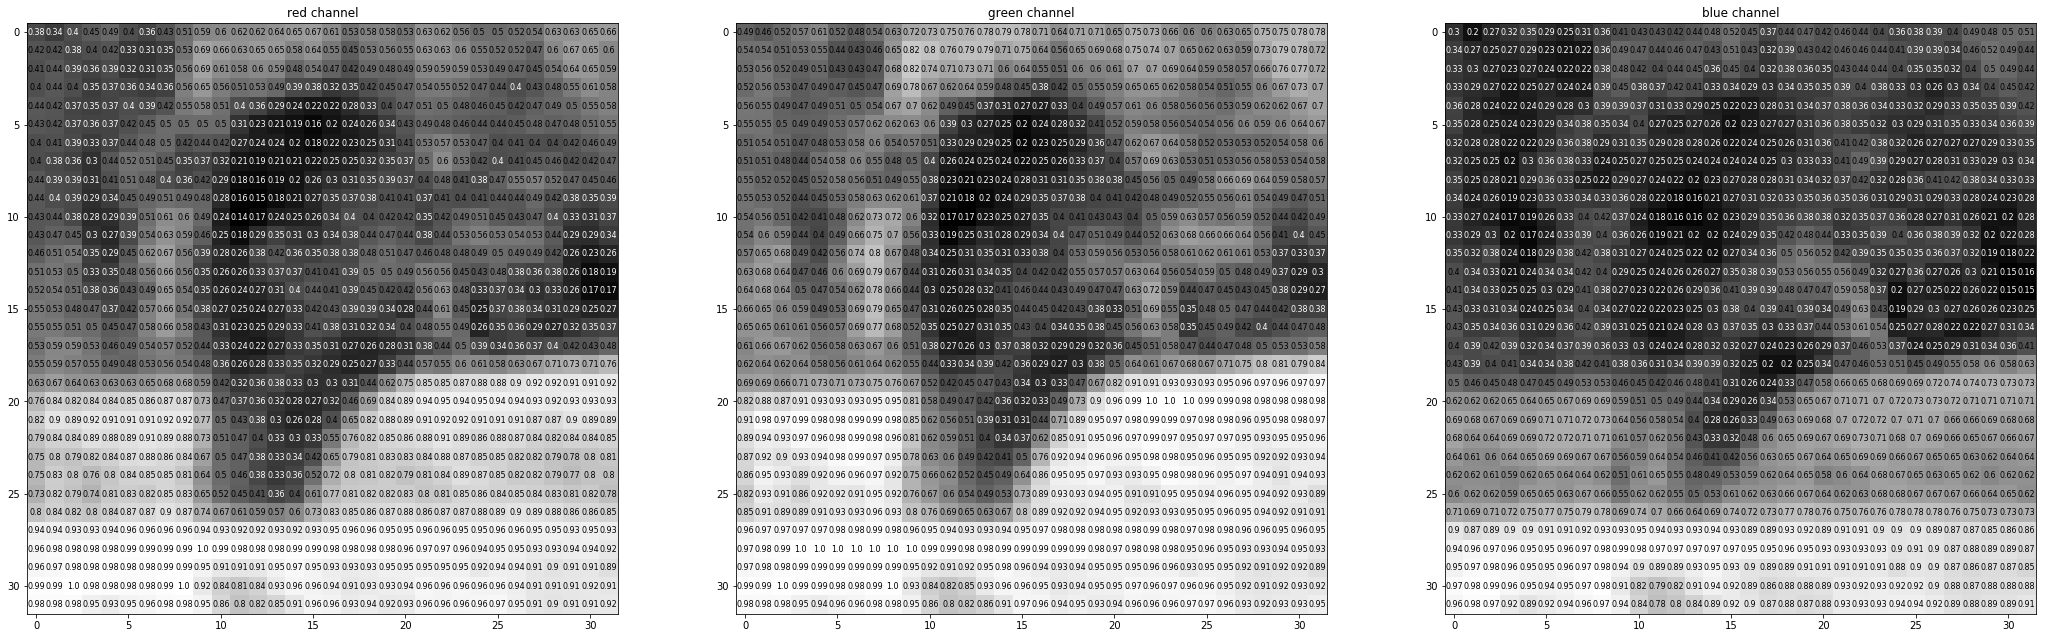

In [11]:
rgb_img = np.squeeze(images[0])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[-1]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[:,:,idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

Below we build a basic convnet. It's a stack of Conv2D and MaxPooling2D layers. Importantly, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In our case, we will configure our convnet to process inputs of size (32, 32, 3), which is the format of CIFAR-10 images. We do this via passing the argument input_shape=(32, 32, 3) to our first layer.

In [12]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

Now, let's train our convnet on the CIFAR-10 dataset. 

## Compile and Train

In [14]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

The steps for training/learning from a batch of data are :

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Keras wraps up all of these steps in one function: `model.fit()`.

Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator, i.e. after having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 32-sample large, so it will take 1562 batches until we see our target of 50000 samples.

When using `fit_generator`, one may pass a validation_data argument, much like with the `fit` method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [24]:
history = model.fit(
      train_generator,
      steps_per_epoch=1562,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=312)

Epoch 1/20
1562/1562 [==============================] - 25s 16ms/step - loss: 1.5308 - acc: 0.4390 - val_loss: 1.3456 - val_acc: 0.5195
Epoch 2/20
1562/1562 [==============================] - 24s 16ms/step - loss: 1.2065 - acc: 0.5741 - val_loss: 1.1471 - val_acc: 0.5918
Epoch 3/20
1562/1562 [==============================] - 24s 16ms/step - loss: 1.0484 - acc: 0.6334 - val_loss: 1.0301 - val_acc: 0.6341
Epoch 4/20
1562/1562 [==============================] - 24s 15ms/step - loss: 0.9485 - acc: 0.6671 - val_loss: 0.9833 - val_acc: 0.6576
Epoch 5/20
1562/1562 [==============================] - 24s 16ms/step - loss: 0.8759 - acc: 0.6898 - val_loss: 0.9584 - val_acc: 0.6706
Epoch 6/20
1562/1562 [==============================] - 24s 15ms/step - loss: 0.8208 - acc: 0.7102 - val_loss: 0.8824 - val_acc: 0.7015
Epoch 7/20
1562/1562 [==============================] - 24s 15ms/step - loss: 0.7680 - acc: 0.7296 - val_loss: 0.8701 - val_acc: 0.7003
Epoch 8/20
1562/1562 [==========================

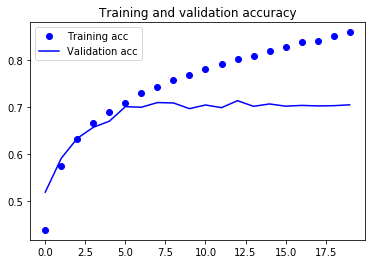

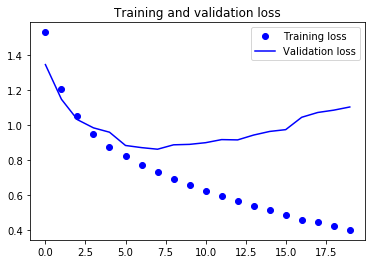

In [28]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation accuracy stops decreasing after about 5 epochs whereas the training accuracy continues to improve. This is an example of overfitting, where the model starts fitting to noisy artifacts in the training data which are not representative features of the true population.

There two most common ways of dealing with overfitting are Regularization (particularly Dropout) and Data Augmentation. We explore Data Augmentation in the next section.

## Data Augmentation

Let's set up our data generators again, this time introducing __data augmentation__ in the training datagen.

In [32]:
# For data Augmentation we intriduce zoom, shifts and random rotations.
train_datagen = ImageDataGenerator(rescale=1./255,
                                  fill_mode = "nearest",
                                  zoom_range = 0.2,
                                  width_shift_range = 0.2,
                                  height_shift_range=0.2,
                                  rotation_range=30)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        directory=data_dir + '/train/',
        # All images will be resized to 32x32
        target_size=(32, 32),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        directory=data_dir + '/test/',
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


#### Visualizing Augmentations 

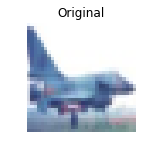

In [46]:
# Original Picture

files_s = os.listdir(data_dir + '/train/airplane')[:20]
x = plt.imread(data_dir + f'/train/airplane/{files_s[5]}')

plt.figure( figsize=(3,2) )
plt.axis('Off')
plt.title('Original')
plt.imshow(x)


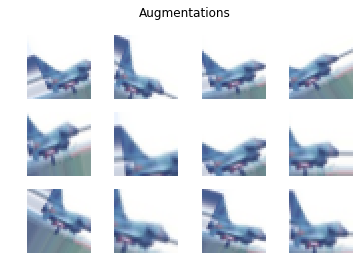

In [47]:
# Augmentations

x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    i += 1
    plt.subplot(3,4,i)
    plt.axis('Off')
    plt.suptitle('Augmentations')
    plt.imshow(batch[0]*255)

    if i > 11:
        break  # otherwise the generator would loop indefinitely

#### Training 

In [48]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [49]:
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=1562,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=312)

Epoch 1/100
1562/1562 [==============================] - 55s 35ms/step - loss: 1.8404 - acc: 0.3166 - val_loss: 1.5826 - val_acc: 0.4280
Epoch 2/100
1562/1562 [==============================] - 54s 35ms/step - loss: 1.5694 - acc: 0.4280 - val_loss: 1.2879 - val_acc: 0.5350
Epoch 3/100
1562/1562 [==============================] - 54s 35ms/step - loss: 1.4506 - acc: 0.4765 - val_loss: 1.2305 - val_acc: 0.5604
Epoch 4/100
1562/1562 [==============================] - 54s 35ms/step - loss: 1.3883 - acc: 0.5016 - val_loss: 1.2237 - val_acc: 0.5667
Epoch 5/100
1562/1562 [==============================] - 54s 35ms/step - loss: 1.3392 - acc: 0.5217 - val_loss: 1.1272 - val_acc: 0.6063
Epoch 6/100
1562/1562 [==============================] - 54s 35ms/step - loss: 1.2970 - acc: 0.5374 - val_loss: 1.1286 - val_acc: 0.6047
Epoch 7/100
1562/1562 [==============================] - 54s 35ms/step - loss: 1.2730 - acc: 0.5443 - val_loss: 1.0467 - val_acc: 0.6248
Epoch 8/100
1562/1562 [==================

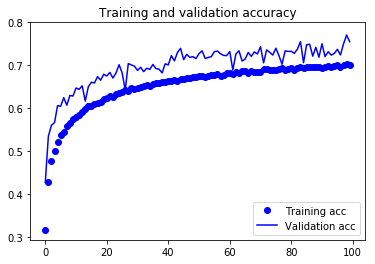

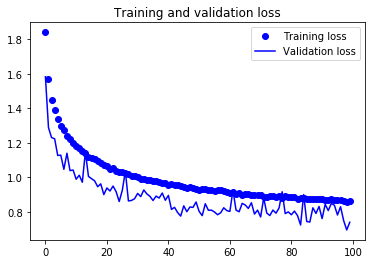

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.yticks(np.arange(0.3,0.82, 0.1))
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that with Augmentation, it becomes a lot harder to overfit. Additionaly we've also improved __validation accuracy from ~70% to ~76%__. From the shape of the plots (since the curves haven't quite flattened yet) one could even argue that we could keep training further.

The state of the art accuracy on cifar-10 is ~ 99% (See [link](https://paperswithcode.com/sota/image-classification-on-cifar-10)). 

Some ideas for reaching accuracies closer to SOA are: experimenting with bigger architectures, using pretrained networks (this technique is known as Transfer Learning), itroducing regularization such as drop-out, batch-normalization, etc.